In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import os

#variable
SUMMARY = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/LR_SummaryTest_Table.tsv'
TSS = '/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/Merged_Causality_TSS_TSS.tab'
ANNOT =  "/storage/mgymrek/gtex/annotations/encode/"
ENHANC = ["Strong_Enhancer","Weak_Enhancer"]

SHORTEN = {
    "Artery-Aorta":"Artery.A"     ,
    "Artery-Tibial": "Artery.T",
    "Adipose-Subcutaneous": "Adipose.S",    
    "Adipose-Visceral":"Adipose.V",
    "Brain-Caudate":"Caudate"   , 
    "Brain-Cerebellum":"Cerebellum",
    "Cells-Transformedfibroblasts": "Fibroblast",
    "Esophagus-Mucosa": "Mucosa",
    "Esophagus-Muscularis":"Muscularis",
    "Heart-LeftVentricle":"Heart",
    "Lung": "Lung",
    "Muscle-Skeletal": "Muscle",
    "Nerve-Tibial":"Nerve",
    "Skin-NotSunExposed": "SkinUnexposed",
    "Skin-SunExposed":"SkinLeg",
    "Thyroid":"Thyroid",
    "WholeBlood": "Blood"
}
TISSUES = [item for item in list(SHORTEN.keys()) if item != "permuted"]
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}

sep='"\t"'
OUTPATH = "../pdfs"
PREFIX = "SupllFigure" # Keep as a variable in case we move things around!

#command = "cat %s |awk -F'\t' '{print $1%s$2%s$75%s$4}' | uniq > all_analyzed_strs.tab"%(SUMMARY, sep,sep,sep)
#value = os.system(command)

In [2]:
#All STRs
allstrs = pd.read_csv(SUMMARY, sep='\t')
allstrs['locus']=allstrs.apply(lambda x: x["chrom"]+":"+str(x["str.start"]), 1)
estrs = allstrs.loc[allstrs['E.tissues']>=1] 
print(allstrs.shape, 'All loci:', len(set(allstrs['locus'])) , estrs.shape, 'eSTR loci:',len(set(estrs['locus'])))


#enhancers
enhancer = {
    'Strong_E': os.path.join(ANNOT,"%s_GM12878.bed"%ENHANC[0]),
    'Weak_E': os.path.join(ANNOT,"%s_GM12878.bed"%ENHANC[1])
            }
#intersect with strong enhancers
command = "bedtools intersect -a all_analyzed_strs.tab -b %s > Intersect.bed"%enhancer['Strong_E']
value = os.system(command)
enhancer['inter_strong'] = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end","gene"]).drop_duplicates()
feature_loci = set(enhancer['inter_strong'].apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
allstrs['inter_strong'] = np.where(allstrs["locus"].isin(feature_loci), 1, 0)


#intersect with weak enhancers
command = "bedtools intersect -a all_analyzed_strs.tab -b %s > Intersect.bed"%enhancer['Weak_E']
value = os.system(command)
enhancer['inter_weak'] = pd.read_csv('Intersect.bed', sep='\t', names=["chrom","start","end","gene"]).drop_duplicates()
feature_loci = set(enhancer['inter_weak'].apply(lambda x: x["chrom"]+":"+str(x["start"]), 1))
allstrs['inter_weak'] = np.where(allstrs["locus"].isin(feature_loci), 1, 0)

(307187, 78) All loci: 125758 (25619, 78) eSTR loci: 20192


In [3]:
#Evaluating overall enrichment

enhan = allstrs.loc[(allstrs['inter_strong']==1)|(allstrs['inter_weak']==1)].copy()
print('All STRs at enhancers', len(set(enhan['locus'])), enhan.loc[enhan['E.tissues']>=1].shape,'eSTRs at enhancers',len(set(enhan.loc[enhan['E.tissues']>=1]['locus'])) )

Eenhan = enhan.loc[enhan['E.tissues']>=1].copy()
Motifs = list(set(Eenhan['motif']))

locus=len(set(allstrs['locus']))
eSTR=len(set(estrs['locus']))
locus_enh = len(set(enhan['locus']))
estr_enh_locus = len(set(enhan.loc[enhan['E.tissues']>=1]['locus']))  
odd_enhancer, pv_enhancer = ss.fisher_exact([[estr_enh_locus,eSTR-estr_enh_locus],[locus_enh-estr_enh_locus, locus-eSTR-(locus_enh-estr_enh_locus)]])
print('Enrichment of eSTRs at enhancer regions',odd_enhancer, pv_enhancer)

odds=[]
pval=[]
count=[]

#overall enrichment #66 eSTRs motifs 
for motif in Motifs:
    me = Eenhan.loc[Eenhan['motif']==motif].shape[0]
    mne= Eenhan.shape[0] - me
    nme= enhan.loc[enhan['motif']==motif].shape[0]-me
    nmne=enhan.shape[0]-enhan.loc[enhan['motif']==motif].shape[0]-(mne) 
    #print([me,mne],[nme,nmne])
    
    OR, p = ss.fisher_exact([[me,mne],[nme,nmne]])
    
    odds.append(np.log2(OR))
    pval.append(p) #(-np.log10(p))
    count.append((enhan.loc[enhan['motif']==motif].shape[0], me))

data1=pd.DataFrame.from_dict({'motif':Motifs, 'OR':odds, 'pvalue':pval, 'Counts':count}).sort_values('pvalue')
data1.index=list(data1['motif'])
data1.head(5)

All STRs at enhancers 2579 (694, 80) eSTRs at enhancers 544
Enrichment of eSTRs at enhancer regions 1.4085963072933756 1.1215757632796984e-11


,Counts,OR,motif,pvalue
CCCCCG,"(6, 3)",3.358010,CCCCCG,0.011501
AGG,"(57, 11)",1.301897,AGG,0.015583
AT,"(131, 19)",0.810013,AT,0.029860
AACC,"(15, 4)",1.899038,AACC,0.038638
A,"(2990, 291)",0.231707,A,0.049652


In [4]:
#Evaluating enrichment in tissues

data = data1.copy()
enhan = allstrs.loc[(allstrs['inter_strong']==1)|(allstrs['inter_weak']==1)].copy()
enrich_tissues = {}
enrich_tissues['motif']=Motifs

Num=0
for T in TISSUES:
    Eenhan = enhan.loc[enhan['eSTR.%s'%SHORTEN[T]]>=1].copy()
    locus=len(set(allstrs['locus']))
    eSTR=len(set(estrs['locus']))
    locus_enh = len(set(enhan['locus']))
    estr_enh_locus = len(set(enhan.loc[enhan['eSTR.%s'%SHORTEN[T]]>=1]['locus']))  
    odd_enhancer, pv_enhancer = ss.fisher_exact([[estr_enh_locus,eSTR-estr_enh_locus],[locus_enh-estr_enh_locus, locus-eSTR-(locus_enh-estr_enh_locus)]])
    print('Enrichment of eSTRs at enhancer regions --->',SHORTEN[T],'\t',odd_enhancer, pv_enhancer)

    Num=Num+0.5
    odds=[]
    pval=[]
    count=[]

    #overall enrichment #66 eSTRs motifs 
    for motif in Motifs:
        me = Eenhan.loc[Eenhan['motif']==motif].shape[0]
        if me==0:
            odds.append(0)
            pval.append(1) 
            count.append((enhan.loc[enhan['motif']==motif].shape[0], me))
            continue
            
        mne= Eenhan.shape[0] - me
        nme= enhan.loc[enhan['motif']==motif].shape[0]-me
        nmne=enhan.shape[0]-enhan.loc[enhan['motif']==motif].shape[0]-(mne) 
        OR, p = ss.fisher_exact([[me,mne],[nme,nmne]])

        odds.append(np.log2(OR))
        pval.append(p) #(-np.log10(p))
        count.append((enhan.loc[enhan['motif']==motif].shape[0], me))
        
    D=pd.DataFrame.from_dict({'motif':Motifs, 'OR':odds, 'pvalue':pval, 'Counts':count})
    D.index=list(D['motif'])
    D['color']= D['pvalue'].apply(lambda x: COLORS[T] if x<=0.05 else 'white')
    data[SHORTEN[T]] = list(D['color'])
    
data2=data.copy()
data.head(5) #= pd.DataFrame.from_dict(enrich_tissues)

Enrichment of eSTRs at enhancer regions ---> Heart 	 0.09350224348839706 0.0
Enrichment of eSTRs at enhancer regions ---> Muscularis 	 0.1532287589120709 1e-323
Enrichment of eSTRs at enhancer regions ---> Mucosa 	 0.18488779539660316 1.2225013313501803e-287
Enrichment of eSTRs at enhancer regions ---> Artery.T 	 0.18420832955477284 2.0305623361118193e-288
Enrichment of eSTRs at enhancer regions ---> SkinLeg 	 0.187608229713895 1.0621643170825717e-284
Enrichment of eSTRs at enhancer regions ---> Lung 	 0.1559013330492614 1.0553e-320
Enrichment of eSTRs at enhancer regions ---> Blood 	 0.1565701067720069 7.364e-320
Enrichment of eSTRs at enhancer regions ---> Caudate 	 0.037651658376790104 0.0
Enrichment of eSTRs at enhancer regions ---> Cerebellum 	 0.07297983528847646 0.0
Enrichment of eSTRs at enhancer regions ---> Fibroblast 	 0.1679779515435321 1.6171039831276562e-306
Enrichment of eSTRs at enhancer regions ---> SkinUnexposed 	 0.13067379868680815 0.0
Enrichment of eSTRs at enhance

,Counts,OR,motif,pvalue,Heart,Muscularis,Mucosa,Artery.T,SkinLeg,Lung,...,Caudate,Cerebellum,Fibroblast,SkinUnexposed,Muscle,Adipose.V,Thyroid,Artery.A,Adipose.S,Nerve
AC,"(6321, 515)",-0.256218,AC,0.000676,white,burlywood,white,white,white,white,...,white,white,white,white,white,white,white,white,darkorange,gold
AT,"(530, 66)",0.501916,AT,0.011908,white,white,white,white,white,white,...,white,white,white,white,white,white,white,white,white,white
CCCCGG,"(6, 3)",3.304519,CCCCGG,0.012574,white,white,white,white,white,white,...,white,white,white,white,white,white,white,white,white,white
AAC,"(458, 56)",0.469271,AAC,0.027357,white,white,white,white,white,white,...,white,white,skyblue,white,white,white,white,white,white,gold
AAG,"(66, 1)",-2.723278,AAG,0.029383,white,white,white,white,white,white,...,white,white,white,white,white,white,white,white,white,white


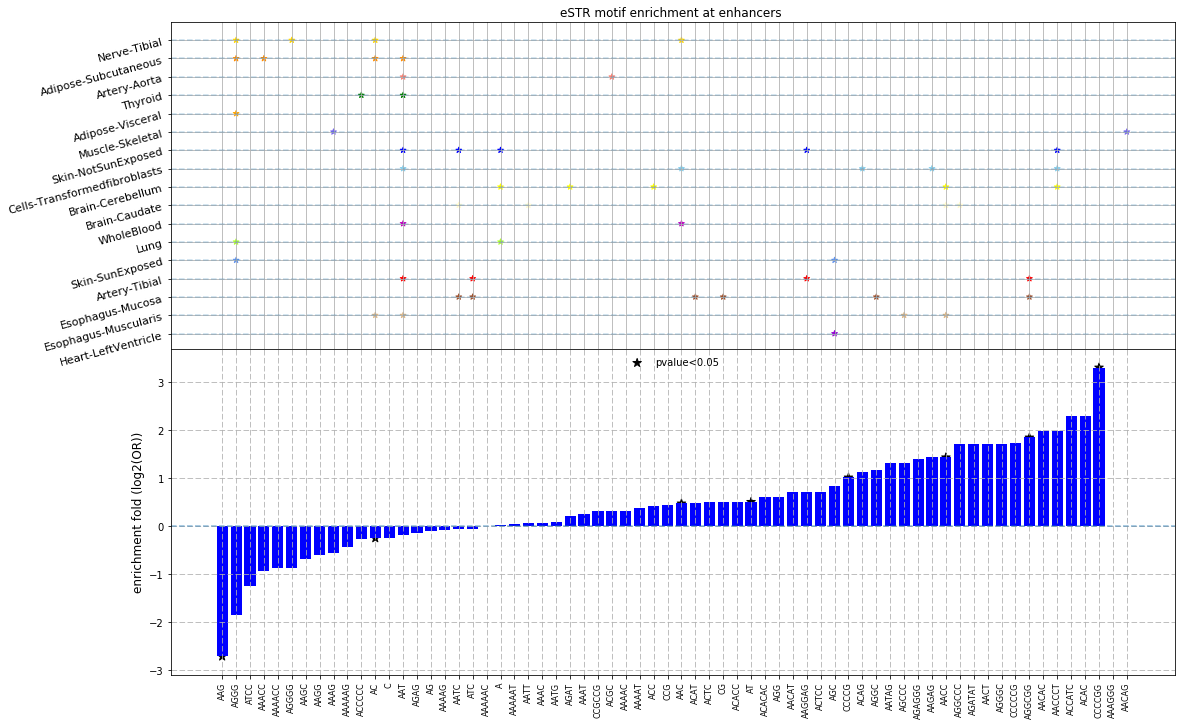

In [5]:
# Plotting enrichment
data=data2.copy()
data=data.sort_values('OR',ascending=True)
X=[i for i in range(data.shape[0])]

fig = plt.figure(figsize=(18,12))
plt.subplots_adjust( hspace=0)
#Summary
bx = fig.add_subplot(211)

Num=0
for i in range(len(TISSUES)):
    T=TISSUES[i]
    Num = Num +1
    Y=[Num]*data.shape[0]
    plt.axhline(y=Num, xmin=0, xmax=1, hold=None, alpha=0.25, ls='--')
    bx.scatter(X, Y, color=list(data[SHORTEN[T]]), marker='*')
    
plt.title("eSTR motif enrichment at enhancers ")    
bx.set_yticks([i for i in range(1,len(TISSUES)+1,1)])
bx.set_yticklabels(TISSUES, size=11, rotation=15);
plt.setp(bx.get_xticklabels(), visible=False)
bx.grid()

#Tissues
ax = fig.add_subplot(212,sharex=bx)
data['color']= data['pvalue'].apply(lambda x: 'black' if x<=0.05 else 'white')

ax.bar(X,data['OR'], color='b')
ax.scatter(X, list(data['OR']), color=list(data['color']), marker='*', s=80, label='pvalue<0.05')

ax.set_xticks(X)
ax.set_xticklabels(list(data.index), size=8, rotation='vertical');
ax.set_ylabel("enrichment fold (log2(OR))", size=12)
ax.grid(linestyle='--')

#ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=10);
ax.legend(loc="upper center", frameon=False);
plt.axhline(y=np.log2(1), xmin=0, xmax=1, hold=None, alpha=0.5, ls='--')
plt.show()
fig.savefig(os.path.join(OUTPATH,'%s_eSTRs_motif_enrichment_at_Enhancers.pdf'%PREFIX ))

In [6]:
data1

,Counts,OR,motif,pvalue
AC,"(6321, 515)",-0.256218,AC,0.000676
AT,"(530, 66)",0.501916,AT,0.011908
CCCCGG,"(6, 3)",3.304519,CCCCGG,0.012574
AAC,"(458, 56)",0.469271,AAC,0.027357
AAG,"(66, 1)",-2.723278,AAG,0.029383
AACC,"(28, 6)",1.430757,AACC,0.038921
AGGCGG,"(15, 4)",1.845212,AGGCGG,0.042789
CCCCG,"(65, 11)",1.010929,CCCCG,0.048181
CCCCCG,"(16, 4)",1.719615,CCCCCG,0.053023
AGGG,"(73, 2)",-1.850402,AGGG,0.064372
